# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
#Import your libraries
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (16,6)

#Fechas
import datetime

#Interact
from ipywidgets import interact

#Umbalanced
from imblearn.under_sampling import NearMiss

#Statsmodels
import statsmodels.api as sm

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC, SVC

from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.decomposition import PCA

Using TensorFlow backend.


In [2]:
paysim1 = pd.read_csv('paysim1.csv')

In [3]:
paysim1.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

**Funciones del proyecto**

In [4]:
def heatmap_ml(df):
    corr = df.corr().round(2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(16, 8))

        ax = sns.heatmap(corr, cmap = 'RdBu_r', annot=True,  mask=mask, vmax=1, vmin= -1, square=True)

In [5]:
def describe_df(df):
    
    """
    Muestra información básica del dataframe que le pases.
    
    Input:
    -DataFrame
    
    Output:
    - Número de filas y columnas
    - DataFrame con:
        * 'type': Tipos de columnas
        * 'nan': Número de valores nulos
        * 'nan_ratio_col': Ratio de valores nulos en la columna
        * 'nan_ratio_total': Ratio de valores nulos en el total del dataset
        * 'unique_values': Número de valores únicos que tiene esa columna
        * 'mean': media de las columnas numéricas
        * 'std': desviación estándard de las columnas numéricas
        * 'min': mínimo de las columnas numéricas
        * '25%': primer cuartil de las columnas numéricas
        * '50%': segundo cuartil de las columnas numéricas
        * '75%': tercer cuartil de las columnas numéricas
        * 'max': máximo de las columnas numéricas
        
    - Heatmap de correlación
    """
    
    print(f'Hay un total de {df.shape[0]} filas y {df.shape[1]} columnas.')
    
    print (heatmap_ml(df))
    
    describe_df = pd.DataFrame(df.dtypes, columns = ["type"])
    describe_df["nan"] = df.isna().sum()
    describe_df["nan_ratio_col"] = [round(df.isna().sum()[col]/len(df[col])*100, 2) for col in df.columns]
    describe_df["nan_ratio_total"] = [round(df.isna().sum()[col]/df.shape[0]*100, 2) for col in df.columns]
    describe_df['unique_values'] = [len(pd.unique(df[col])) for col in df.columns]
    describe_df = describe_df.join(df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], on = describe_df.index)
    
    return describe_df

In [6]:
def cat_column_analysis(df, col, x):
    
    """
    Dada un columna devuelve información relacionada con nulos y distribución.
    
    Inputs:
    df. datafrme
    col. nombre de la columna
    x. dependable variable
    
    Output:
    -Valores nulos y su ratio si hay.
    -% de cada valor
    -bar plot
    
    """
    
    df_temp = pd.DataFrame(df[col])
    
    #Valores nulos
    if df[col].isnull().sum()>0:  
        print(f"Valores nulos: {df[col].isnull().sum()}. Un {round((df[col].isnull().sum()/len(df[col])*100),2)}%")
        df_temp[col] = df[col].fillna("NaN")
    else:
        print("No hay valores nulos.")
        
    # % según los valores únicos    
    print("Ratio de valores:")
    cd = pd.DataFrame(df_temp[col].value_counts())
    cd["%"] = [round((cd[col][value]/cd[col].sum()),4)*100 for value in cd.index]
    print(cd)
    
    #Visualización de la distribución
    print("Distribución:")
    display(df_temp[col].hist())
    plt.show()
    
    print('\n')
    
    #mostrar el impacto de las distintos valores de la variable en el target (No-show)
    df_temp2 = pd.DataFrame(df[[col, x]])

    print(f"Impacto de {col} en {x}:")

    df_temp2 = df_temp2.groupby([col,'isFraud']).agg({col:'count'})
    df_temp2['%'] = [round((df_temp2[col][value]/df_temp2[col][df_temp2.index.get_level_values(0)==value[0]].sum())*100,2)
    for value in df_temp2.index]
    print(df_temp2)

In [7]:
def under_sampling_nr(df, col_dep):
    
    """
    Devuelve el df reducido con NearMiss
    Input:
    *df
    *col_dep: variable dependiente
    
    """
    
    X = df.drop(col_dep, axis = 1)
    y = df[col_dep]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    nr = NearMiss(version = 3)
    nr = NearMiss()
    X_res, y_res = nr.fit_sample(X_train, y_train)
    
    df_temp = pd.DataFrame(X_res, columns = df.columns[:-1])
    df_temp[col_dep] = y_res
    
    return df_temp

In [8]:
paysim1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
paysim1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Hay un total de 6362620 filas y 11 columnas.
None


,type,nan,nan_ratio_col,nan_ratio_total,unique_values,mean,std,min,25%,50%,75%,max
step,int64,0,0.0,0.0,743,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
type,object,0,0.0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,float64,0,0.0,0.0,5316900,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
nameOrig,object,0,0.0,0.0,6353307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,float64,0,0.0,0.0,1845844,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,float64,0,0.0,0.0,2682586,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
nameDest,object,0,0.0,0.0,2722362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,float64,0,0.0,0.0,3614697,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,float64,0,0.0,0.0,3555499,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,int64,0,0.0,0.0,2,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00


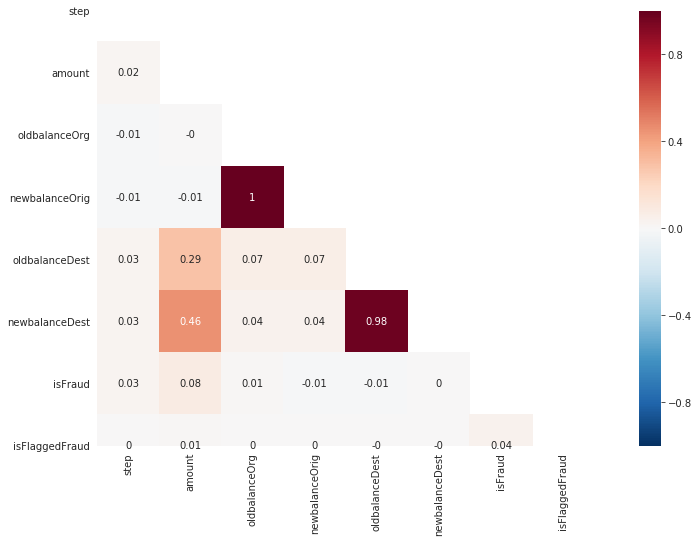

In [10]:
describe_df(paysim1)

Altamente correlacionados son: 

+ newbalanceOrig - oldbalanceOrg
+ newbalanceDest - oldbalanceDest

No hay valores nulos.
Ratio de valores:
             type      %
CASH_OUT  2237500  35.17
PAYMENT   2151495  33.81
CASH_IN   1399284  21.99
TRANSFER   532909   8.38
DEBIT       41432   0.65
Distribución:


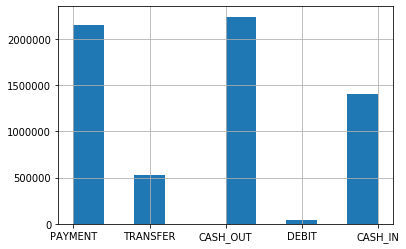



Impacto de type en isFraud:
                     type       %
type     isFraud                 
CASH_IN  0        1399284  100.00
CASH_OUT 0        2233384   99.82
         1           4116    0.18
DEBIT    0          41432  100.00
PAYMENT  0        2151495  100.00
TRANSFER 0         528812   99.23
         1           4097    0.77


In [11]:
cat_column_analysis(paysim1, 'type', 'isFraud')

Variables sin Fraude no interesan. Nos deberíamos quedarons con `CASH_OUT` y con `TRANSFER` 

In [12]:
paysim1['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### What is the distribution of the outcome? 

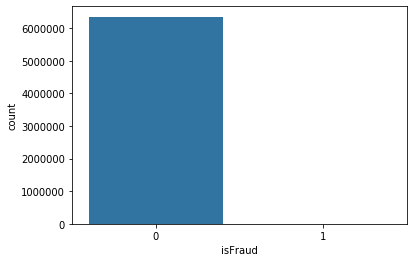

In [13]:
# Your response here
sns.countplot(x="isFraud", data=paysim1)

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [14]:
paysim1 = paysim1[paysim1['type'].str.contains('CASH_OUT|TRANSFER')]

In [15]:
paysim1['type'].unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [16]:
paysim1 = paysim1.drop('newbalanceDest', axis = 1)

In [17]:
paysim1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

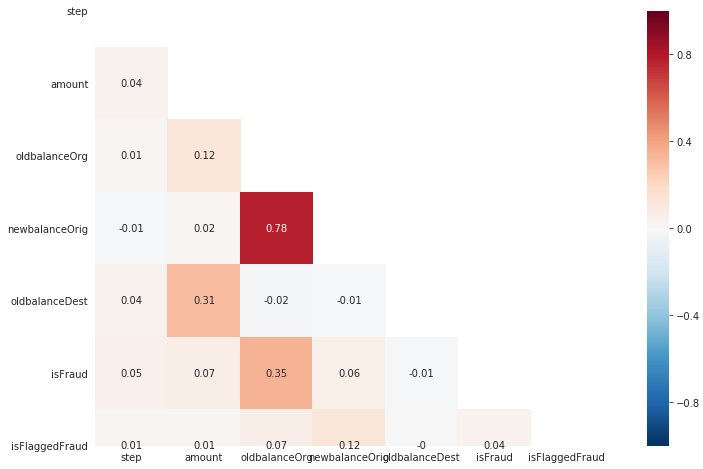

In [18]:
# Your code here
heatmap_ml(paysim1)

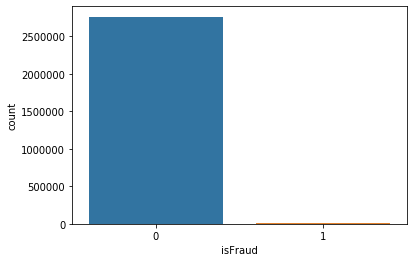

In [19]:
sns.countplot(x="isFraud", data=paysim1)

In [20]:
paysim1.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [21]:
paysim1 = paysim1.drop(['nameOrig', 'nameDest'], axis = 1)

In [22]:
paysim1 = pd.get_dummies(paysim1, columns = ['type'])

In [23]:
paysim = under_sampling_nr(paysim1, 'isFraud')

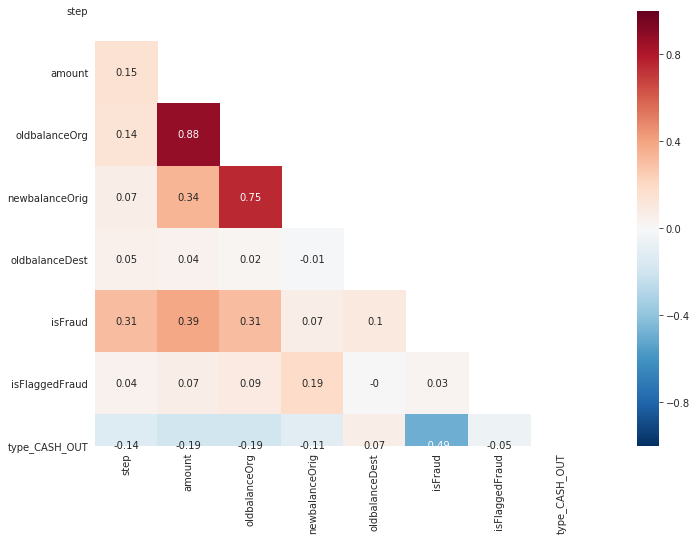

In [24]:
heatmap_ml(paysim)

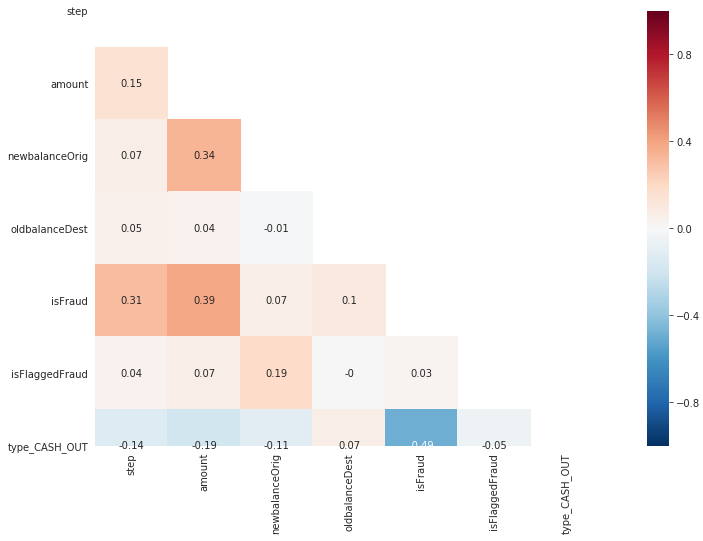

In [25]:
paysim = paysim.drop('oldbalanceOrg', axis = 1)
heatmap_ml(paysim)

In [26]:
print(paysim.shape)
paysim['isFraud'].value_counts()

(12320, 7)


1    6160
0    6160
Name: isFraud, dtype: int64

### Run a logisitc regression classifier and evaluate its accuracy.

In [27]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(paysim.drop('isFraud', axis=1),
                                                    paysim['isFraud'], random_state = 42, test_size=0.2)

In [28]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

Training set accuracy: 0.812
Test set accuracy: 0.806


In [29]:
y_pred = logreg.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[987 264]
 [215 998]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1251
           1       0.79      0.82      0.81      1213

    accuracy                           0.81      2464
   macro avg       0.81      0.81      0.81      2464
weighted avg       0.81      0.81      0.81      2464



### Now pick a model of your choice and evaluate its accuracy.

In [30]:
# Your code here

### Which model worked better and how do you know?

In [31]:
# Your response here